# Data Scientist Professional Case Study

### Company Background

Inn the Neighborhood is an online platform that allows people to rent out their properties for short stays. At the moment, only 2% of people who come to the site interested in renting out their homes start to use it.

The product manager would like to increase this. They want to develop an application to help people estimate how much they could earn renting out their living space. They hope that this would make people more likely to sign up.



### Customer Question

The product manager would like to know:
- Can you develop a way to predict how much someone could earn from renting their property that could power the application?




### Success Criteria

They want to avoid estimating prices that are more than 25 dollars off of the actual price, as this may discourage people.


### Dataset

The data you will use for this analysis can be accessed here: `"data/rentals.csv"`

Summary of changes

I cleaned all string characters for the price colum and change the type for float

I withdrew all NaN values

I withdrew outliers from the bedrooms column, the outliners was : 14,7,8.

I withdrew the outliers from the bathrooms column, the outliner was 7.

I kept in the data frame just the minimum nights of rent most common

I kept in the data frame just the rent prices most common

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import TransformedTargetRegressor

In [3]:
rentals=pd.read_csv("data/rentals.csv")
print(rentals.head())

     id  latitude  longitude property_type        room_type  bathrooms  \
0   958  37.76931 -122.43386     Apartment  Entire home/apt        1.0   
1  3850  37.75402 -122.45805         House     Private room        1.0   
2  5858  37.74511 -122.42102     Apartment  Entire home/apt        1.0   
3  7918  37.76669 -122.45250     Apartment     Private room        4.0   
4  8142  37.76487 -122.45183     Apartment     Private room        4.0   

   bedrooms  minimum_nights     price  
0       1.0               1  $170.00   
1       1.0               1   $99.00   
2       2.0              30  $235.00   
3       1.0              32   $65.00   
4       1.0              32   $65.00   


In [4]:
rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8111 entries, 0 to 8110
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              8111 non-null   int64  
 1   latitude        8111 non-null   float64
 2   longitude       8111 non-null   float64
 3   property_type   8111 non-null   object 
 4   room_type       8111 non-null   object 
 5   bathrooms       8099 non-null   float64
 6   bedrooms        8107 non-null   float64
 7   minimum_nights  8111 non-null   int64  
 8   price           8111 non-null   object 
dtypes: float64(4), int64(2), object(3)
memory usage: 570.4+ KB


Cleaning the price column

In [5]:
rentals['price']=rentals['price'].str.strip('$')
rentals['price']=rentals['price'].str.strip(' ')
rentals['price']=rentals['price'].str.replace(',','')

In [6]:
rentals['price']=rentals['price'].astype(float)

Dropping the NaN values

In [7]:

print(rentals.isna().sum())
rentals.dropna(inplace=True)

id                 0
latitude           0
longitude          0
property_type      0
room_type          0
bathrooms         12
bedrooms           4
minimum_nights     0
price              0
dtype: int64


In [8]:
print(rentals.property_type.value_counts())

Apartment             3234
House                 2313
Condominium            892
Guest suite            577
Boutique hotel         267
Hotel                  157
Townhouse              142
Serviced apartment     121
Loft                    88
Hostel                  86
Bed and breakfast       43
Aparthotel              41
Guesthouse              41
Other                   24
Bungalow                17
Resort                  14
Cottage                 12
Villa                   10
Castle                   4
Tiny house               3
Cabin                    3
Earth house              2
In-law                   1
Hut                      1
Camper/RV                1
Dome house               1
Name: property_type, dtype: int64


1.0     4833
2.0     1472
0.0      854
3.0      694
4.0      193
5.0       37
6.0        9
8.0        1
7.0        1
14.0       1
Name: bedrooms, dtype: int64


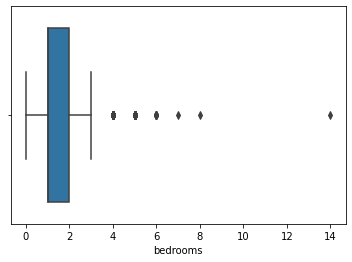

In [9]:
sns.boxplot(x=rentals['bedrooms'])
print(rentals['bedrooms'].value_counts().astype(int))

Dropping the most uncommon numbers os bedrooms

In [10]:
#I didn't drop 0 because some property types could have 0 bedrooms
drop=[14,7,8]
rentals['bedrooms']=rentals['bedrooms'].astype(int)
for i in drop:
	rentals=rentals.drop(rentals[rentals.bedrooms == i].index)

1     6247
2     1345
3      211
5      113
4       73
0       55
10      19
8       14
6       10
7        5
Name: bathrooms, dtype: int64


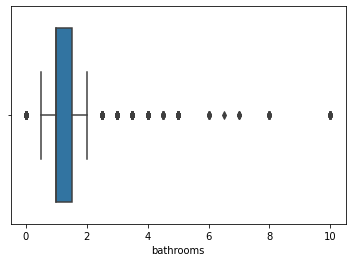

In [11]:
sns.boxplot(x=rentals['bathrooms'])
print(rentals['bathrooms'].astype(int).value_counts())

Dropping the most uncommon numbers os bathrooms

In [12]:
#I didn't drop 0 because some propertys types could have 0 bathrooms
rentals=rentals.drop(rentals[rentals.bathrooms == 7].index)
rentals['bedrooms']=rentals['bedrooms'].astype(int)

Here I make a list of the numbers of mininum nights most uncommon

In [13]:
aux1=list(rentals.minimum_nights.value_counts().index)
drop_2=aux1[13:]

Dropping the number of minimum nights more uncommon

In [14]:
for i in drop_2:
	rentals=rentals.drop(rentals[rentals.minimum_nights ==i].index)
print(rentals.minimum_nights.value_counts())

30     3262
2      1552
1      1417
3       862
4       322
5       216
31      114
7        73
32       60
60       40
6        36
90       31
180      18
Name: minimum_nights, dtype: int64


In [15]:
#Here I make a list of least common price for the rent of properties
aux2=list(rentals.price.value_counts().index)

#drop the prices of rent more uncommon
drop_3=aux2[230:]
for i in drop_3:
    rentals=rentals.drop(rentals[rentals.price==i].index)

In [16]:
rentals_dummies=pd.get_dummies(rentals)
X=rentals_dummies.drop(columns=['price','id'])
y=rentals_dummies.price 

In [17]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state=42)

I chose a regressor model because is the most correct when the target are continous as
 a price of a rent

In [18]:
model = TransformedTargetRegressor(#I used this for make y follow a normal distribution
    regressor=RandomForestRegressor(),#RandomForestRegressor() was the model with the better r^2 score
    transformer=QuantileTransformer(n_quantiles=900, output_distribution="normal")#Transforming to a normal distribution
)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
print(r2_score(y_test,y_predict)*100)#Using r^2 because I want to see if the model can make 
									 #predictions closest of the expect values

85.11359043104618


In [19]:
result={'y':y_test,'Predict':y_predict}
result_df=pd.DataFrame(result)

Here It's possible to see that some values respect the sucess criteria, but others not.The model need improvements but in this moment I don't know what to do. I tried to keep the most data as possible.

In [20]:
print(result_df.head(10))

          y     Predict
6565  110.0  150.000000
2121  129.0   97.961894
3302  200.0  199.000000
3338  122.0  125.108053
3699   40.0   75.000000
7120   45.0   45.000000
6478  110.0  135.000000
2898  125.0  149.000000
7502  208.0  229.374865
4458   79.0   76.000000


The company should try to fix a price range for rent values, looking for focus on specific types of properties.